# Predicting Caravan Insurance Purchases #

This project explores a dataset compiled by *Caravan Insurance* about whether customers purchased their mobile home insurance. Using various classification models, we will attempt to predict whether a person will purchase Caravan insurance (as opposed to another company's comparable insurance) based on demographic information.

NOTE: After looking over my results, I suspect there may be some data leakage going on. The next step for this project is to re-run the analysis ensuring no leakage occurs.

## Contents ##
* **Part 1: Data Exploration**
    * Initial Data Exploration
* **Part 2: Test, Train, Split**
    * Ratio-Preserved Data
* **Part 3: Classify**
    * Logistic Regression, K-NN, LDA, QDA, and SVC with:
        * Un-Normalized, Ratio-Preserved
        * Normalized Data
        * Under Sampling
        * Over Sampling
        * SMOTE
        * PCA + SMOTE
* **Part 4: Features**
    * Removing Signal-Less Features
    * Fewer Features + Over Sampling

## Part 1: Data Exploration ##

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import warnings
import math
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.cross_validation import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
np.random.seed(9)

### Initial Data Exploration ###

In [3]:
# Read in the data.
caravan_df_raw = pd.read_csv('caravan.csv')

In [4]:
# Check shape.
caravan_df_raw.shape

(5822, 86)

In [5]:
# Sample of the data.
caravan_df_raw.head(3)

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No


In [6]:
# List out all columns.
caravan_df_raw.columns

Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK',
       'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG',
       'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA',
       'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
       'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575',
       'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR',
       'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG',
       'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG',
       'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED',
       'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT',
       'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM',
       'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL',
       'APLEZIER', 'AFIETS',

The features are not explicit and so we will need to forge ahead without a clear understanding of the collection of predictors we are working with.

**`Purchase`** is our binary outcome variable, and represents whether or not the customer bought Caravan insurance:

    Yes = Purchased
    No = Did Not Purchase
    
This is what we ultimately hope to predict.

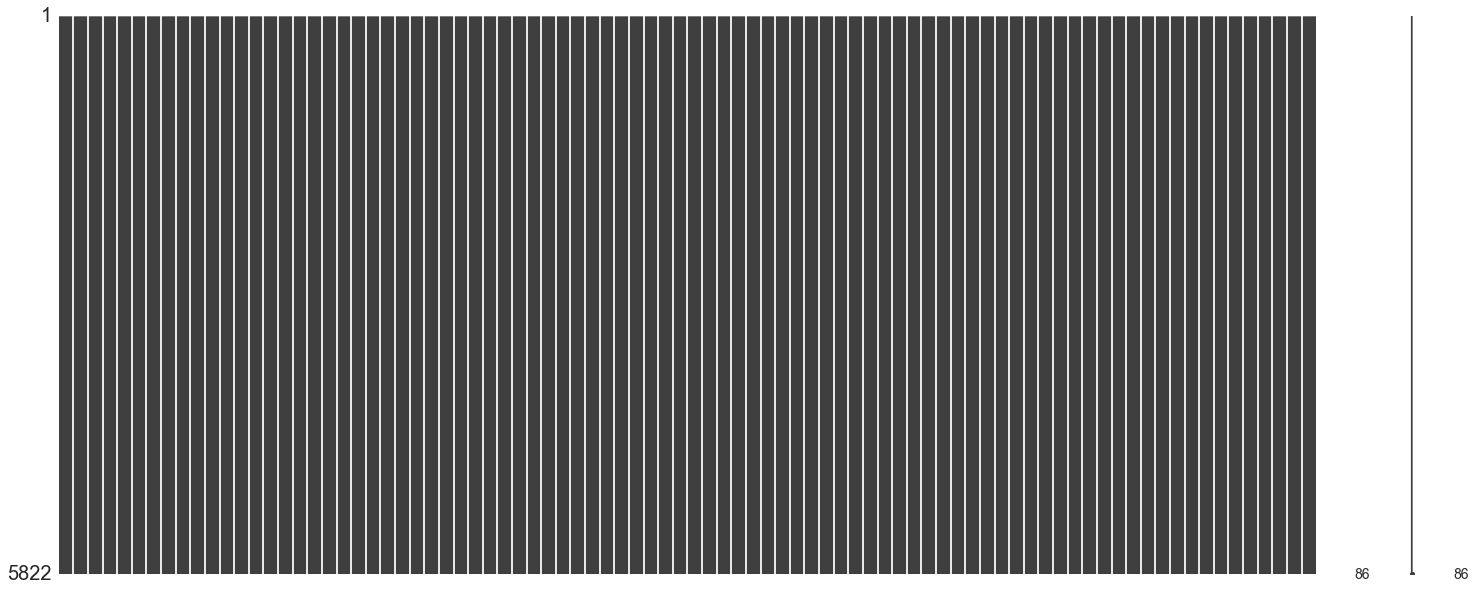

In [7]:
# Visualize missing data.
msno.matrix(caravan_df_raw)

In [8]:
# Ensure there are no missing values.
print('Missing values: %i' % caravan_df_raw.isnull().sum().sum())

Missing values: 0


In [9]:
# Find out which columns are numeric.
numeric_df = caravan_df_raw.select_dtypes(include=[np.number])
numeric_df.shape

(5822, 85)

`85` out of `86` columns are numeric, and we know that `Purchase` is not, so `Purchase` must be the only non-numeric column.

In [10]:
# Purchase has string values.
caravan_df_raw['Purchase'].value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [11]:
# Change string values to binary.
caravan_df_raw['Purchase'] = caravan_df_raw['Purchase'].factorize()[0]
caravan_df_raw['Purchase'].value_counts()

0    5474
1     348
Name: Purchase, dtype: int64

We'll now do some exploratory data analysis on the features, but we'll keep the outcome variable in the dataset.

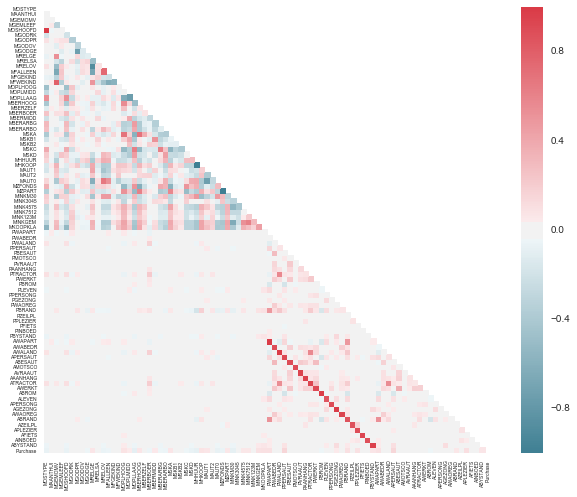

In [12]:
# Look globally at correlation of features.
corr = caravan_df_raw.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax1.set_axis_bgcolor('white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, ax=ax1)
ax1.tick_params(labelsize=5)

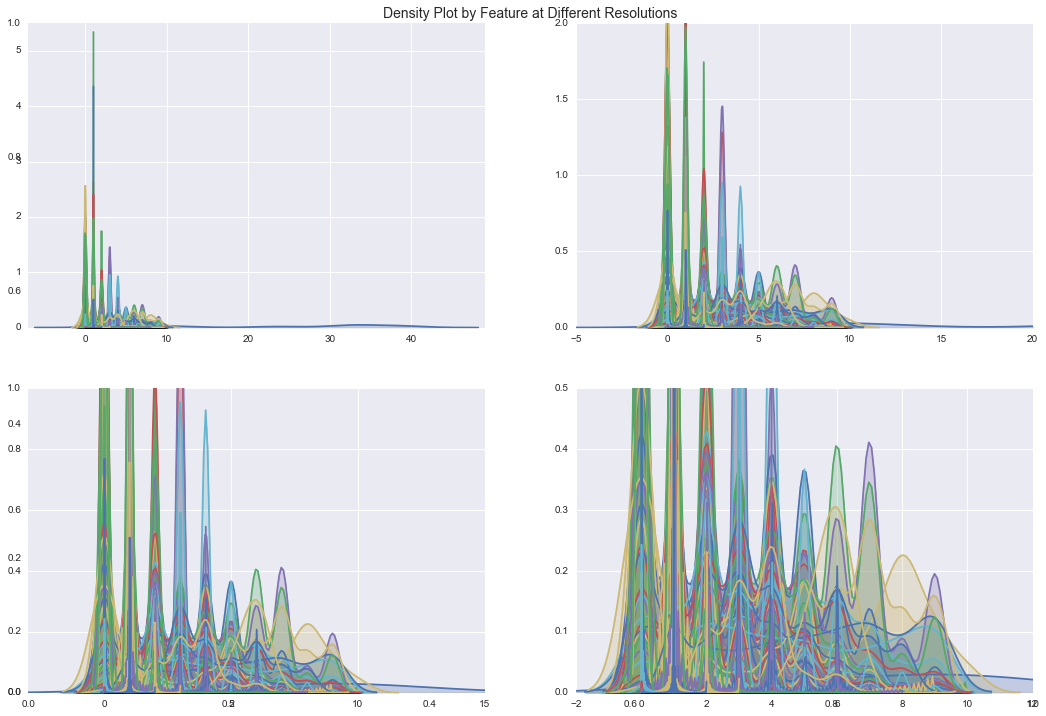

In [13]:
# Visualize feature value distribution.
fig = plt.figure(figsize=(18,12))
plt.title('Density Plot by Feature at Different Resolutions', size=14)
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('white')
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_ylim([0, 5.5])
ax1.set_xlim([-7, 49])
ax2.set_ylim([0, 2])
ax2.set_xlim([-5, 20])
ax3.set_ylim([0, 1])
ax3.set_xlim([-3, 15])
ax4.set_ylim([0, 0.5])
ax4.set_xlim([-2, 12])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
for i in range(0, len(caravan_df_raw.columns) - 1):
    sns.kdeplot(caravan_df_raw.iloc[:,i], ax=ax1, shade=True, legend=False)
for i in range(0, len(caravan_df_raw.columns) - 1):
    sns.kdeplot(caravan_df_raw.iloc[:,i], ax=ax2, shade=True, legend=False)
for i in range(0, len(caravan_df_raw.columns) - 1):
    sns.kdeplot(caravan_df_raw.iloc[:,i], ax=ax3, shade=True, legend=False)
for i in range(0, len(caravan_df_raw.columns) - 1):
    sns.kdeplot(caravan_df_raw.iloc[:,i], ax=ax4, shade=True, legend=False)

In [14]:
# Get summary statistics.
summ_stats = caravan_df_raw.describe()

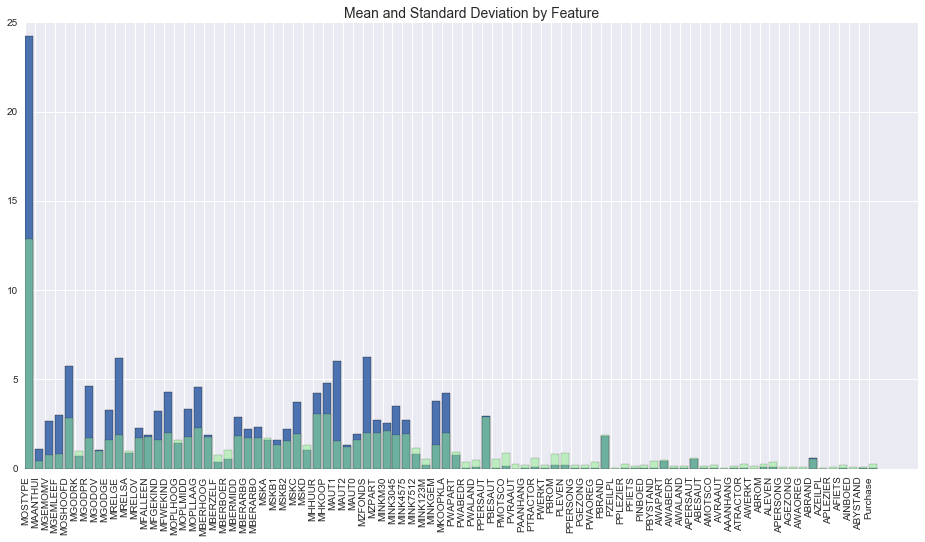

In [15]:
# Plot mean and std for each feature in order.
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
objects = caravan_df_raw.columns
x_pos = np.arange(len(objects))
ax1 = plt.bar(x_pos, summ_stats.loc['mean'], alpha=1)
ax1 = plt.bar(x_pos, summ_stats.loc['std'], alpha=0.5, color='lightgreen')
plt.xticks(x_pos, objects)
plt.xticks(rotation=90);
plt.title('Mean and Standard Deviation by Feature', size=14)

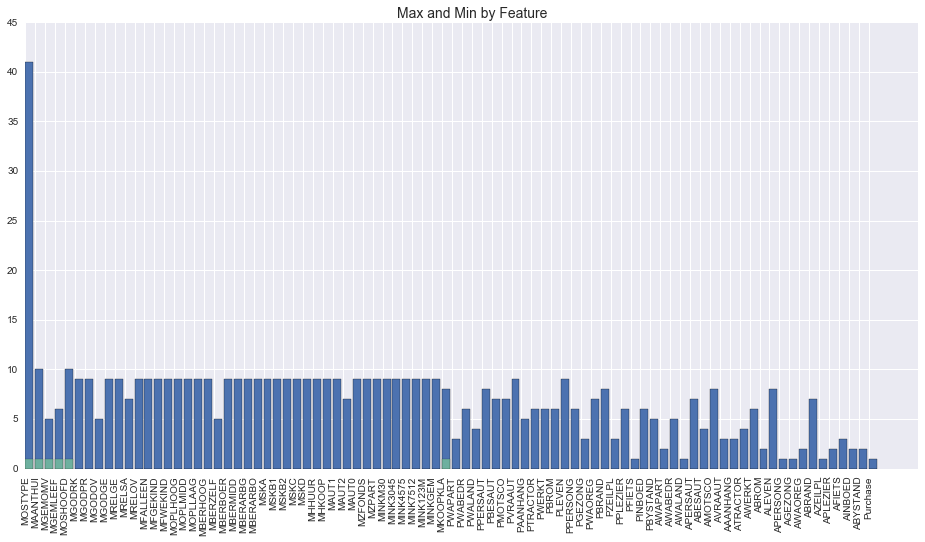

In [16]:
# Plot max and min for each feature in order.
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
objects = caravan_df_raw.columns
x_pos = np.arange(len(objects))
ax1 = plt.bar(x_pos, summ_stats.loc['max'], alpha=1)
ax1 = plt.bar(x_pos, summ_stats.loc['min'], alpha=0.5, color='lightgreen')
plt.xticks(x_pos, objects)
plt.xticks(rotation=90);
plt.title('Max and Min by Feature', size=14)

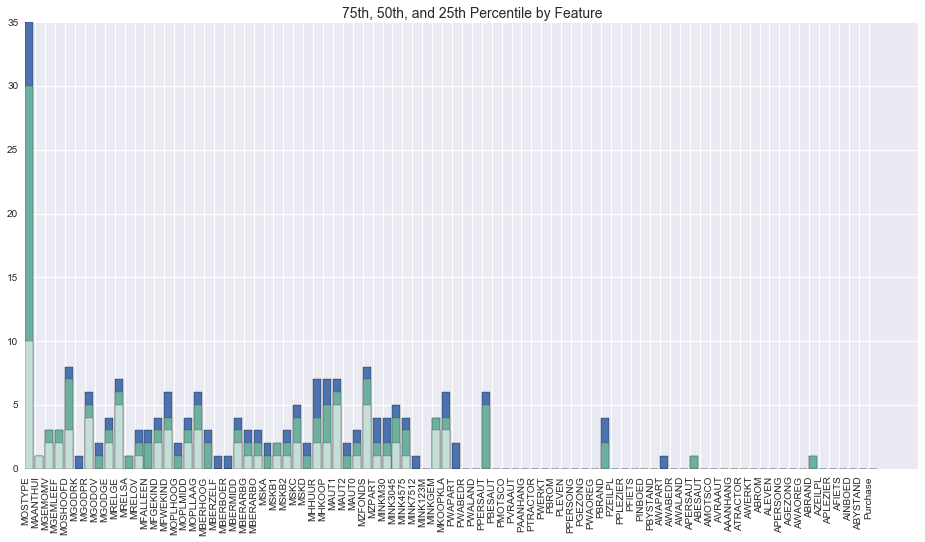

In [17]:
# Plot 75th, 50th, and 25th percentile for each feature in order.
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
objects = caravan_df_raw.columns
x_pos = np.arange(len(objects))
ax1 = plt.bar(x_pos, summ_stats.loc['75%'], alpha=1)
ax1 = plt.bar(x_pos, summ_stats.loc['50%'], alpha=0.5, color='lightgreen')
ax1 = plt.bar(x_pos, summ_stats.loc['25%'], alpha=0.6, color='white')
plt.xticks(x_pos, objects)
plt.xticks(rotation=90);
plt.title('75th, 50th, and 25th Percentile by Feature', size=14)

In [18]:
# Build list of zero values for each feature.
num_zeros = []
for i in range(0, len(caravan_df_raw.columns)):
    num_nonzero = len(caravan_df_raw.iloc[:,i].nonzero()[0])
    num_zeros.append(caravan_df_raw.shape[0] - num_nonzero)

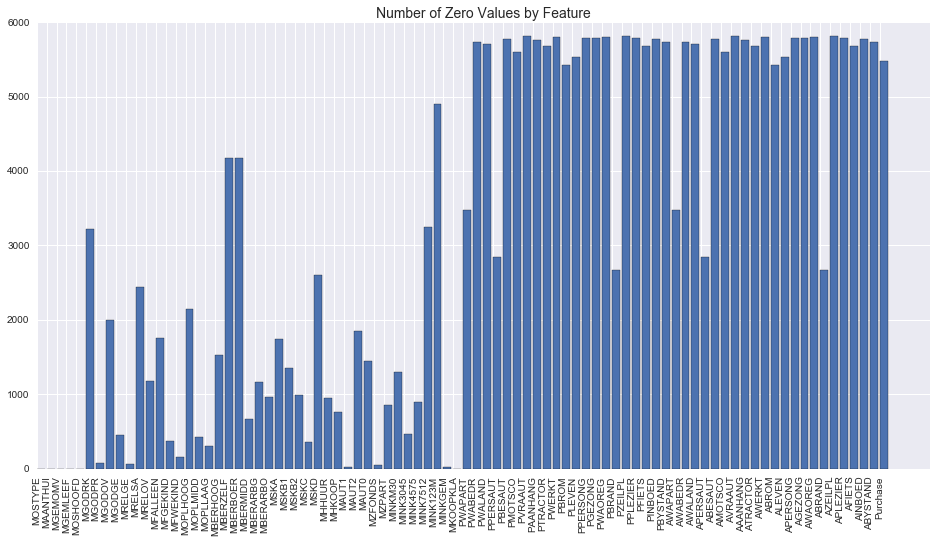

In [19]:
# Plot number of zero values for each feature in order.
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
objects = caravan_df_raw.columns
x_pos = np.arange(len(objects))
ax1 = plt.bar(x_pos, num_zeros)
plt.xticks(x_pos, objects)
plt.xticks(rotation=90);
plt.title('Number of Zero Values by Feature', size=14)

## Test Train Split ##

In [20]:
# Shuffle the data randomly. Random seed already set above.
shuffled_df = caravan_df_raw.sample(frac=1).reset_index(drop=True)

In [21]:
# Recall dataset imbalance.
shuffled_df['Purchase'].value_counts()

0    5474
1     348
Name: Purchase, dtype: int64

In [22]:
# Get ratio of 1s to 0s.
ratio_ones = shuffled_df['Purchase'].value_counts()[1]/(shuffled_df['Purchase'].value_counts()[0] + 
                                                        shuffled_df['Purchase'].value_counts()[1])

We want our training and test data to respect the imbalance in our dataset with with respect to the outcome variable's value. We'll do an 80%/20% split, with 80% for training and 20% for test.

In [23]:
# Recall size of dataset.
shuffled_df.shape

(5822, 86)

In [24]:
# Get size of training and test sets.
train_size = int(shuffled_df.shape[0]*.80)
test_size = shuffled_df.shape[0]-train_size
print('Training set size: %i' % train_size)
print('Test set size: %i' % test_size)

Training set size: 4657
Test set size: 1165


In [25]:
# Get number of 1s and 0s in Purchase column for training set.
train_num_ones = math.ceil(train_size*(ratio_ones))
train_num_zeros = train_size-train_num_ones
print('Training set 1s: %i' % train_num_ones)
print('Training set 0s: %i' % train_num_zeros)

Training set 1s: 279
Training set 0s: 4378


In [26]:
# Get number of 1s and 0s in Purchase column for test set.
test_num_ones = int(test_size*(ratio_ones))
test_num_zeros = test_size-test_num_ones
print('Test set 1s: %i' % test_num_ones)
print('Test set 0s: %i' % test_num_zeros)

Test set 1s: 69
Test set 0s: 1096


In [27]:
# Split shuffled data according to the proper ratios.
test_df = shuffled_df[shuffled_df['Purchase'] == 1][:test_num_ones]
train_df = shuffled_df[shuffled_df['Purchase'] == 1][test_num_ones:]
test_df = test_df.append(shuffled_df[shuffled_df['Purchase'] == 0][:test_num_zeros])
train_df = train_df.append(shuffled_df[shuffled_df['Purchase'] == 0][test_num_zeros:])

In [28]:
# Verify that the split went according to plan.
print(test_df['Purchase'].value_counts())
print(train_df['Purchase'].value_counts())

0    1096
1      69
Name: Purchase, dtype: int64
0    4378
1     279
Name: Purchase, dtype: int64


In [29]:
# Reset training and test dataset indexes.
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [30]:
# Split training set into features X and label y.
y_train = train_df['Purchase']
X_train = train_df.drop(['Purchase'], axis=1)

In [31]:
# Split test set into features X and label y.
y_test = test_df['Purchase']
X_test = test_df.drop(['Purchase'], axis=1)

## Classify ##

### Logistic Regression ###

In [57]:
# Classify with Logistic Regression.
lr = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr = GridSearchCV(lr, parameters, cv=10)
clf_lr.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [58]:
# Find the best of our logistic regression models.
best_lr = clf_lr.best_estimator_
best_lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
# Make predictions based on our best model.
y_hat_lr = best_lr.predict(X_test)

In [60]:
# Examine confusion matrix for best logistic regression model.
confusion_matrix(y_test, y_hat_lr, labels=[1,0])

array([[   0,   69],
       [   3, 1093]])

In [61]:
# Get ROC curve and AUC.
y_hat_proba = best_lr.predict_proba(X_test)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, y_hat_proba[:,1])
lr_roc_auc = auc(lr_fpr, lr_tpr)

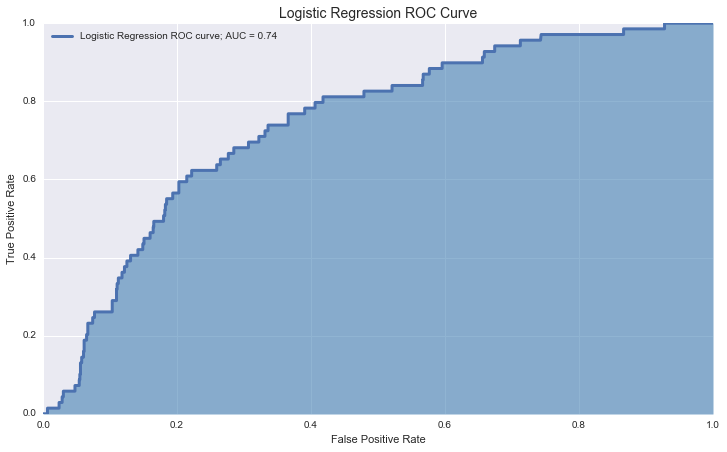

In [62]:
# Plot ROC curve and AUC for our logistic regression model.
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(lr_fpr, lr_tpr, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(lr_fpr, lr_tpr, linewidth=3, label='Logistic Regression ROC curve; AUC = %0.2f' % lr_roc_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve', size=14)

In [63]:
# Examine other metrics.
print(classification_report(y_test, y_hat_lr))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1096
          1       0.00      0.00      0.00        69

avg / total       0.88      0.94      0.91      1165



Since we want to correctly classify the 1s, we can see our model isn't doing terribly well.

In [66]:
# Just to rule it out, try a non-manual split using train_test_split().
X = shuffled_df.drop(['Purchase'], axis=1)
y = shuffled_df['Purchase']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.20, random_state=9)

In [67]:
# Examine the split.
print(y_test2.value_counts())
print(y_train2.value_counts())

0    1106
1      59
Name: Purchase, dtype: int64
0    4368
1     289
Name: Purchase, dtype: int64


In [68]:
# Logistic Regression.
lr2 = LogisticRegression()
parameters2 = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr2 = GridSearchCV(lr2, parameters2, cv=10)
clf_lr2.fit(X_train2, y_train2)
best_lr2 = clf_lr2.best_estimator_
y_hat_lr2 = best_lr2.predict(X_test2)
confusion_matrix(y_test2, y_hat_lr2, labels=[1,0])

array([[   1,   58],
       [   2, 1104]])

Though the results depend on the random seed, when we didn't explicitly preserve the ratio of 1s to 0s in the training and test data, our model correctly classified a few more data points. But taking into account the variation depending on the random seed, we can see our model is performing roughly the same as before.

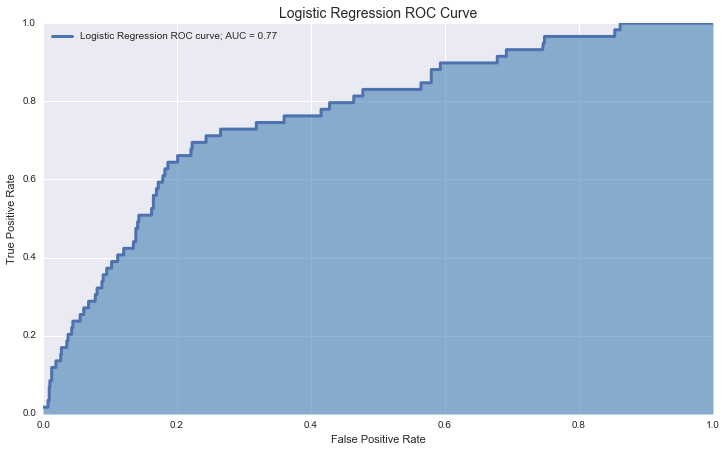

In [69]:
# Examine ROC curve and AUC.
y_hat_proba2 = best_lr2.predict_proba(X_test2)
lr_fpr2, lr_tpr2, thresholds2 = roc_curve(y_test2, y_hat_proba2[:,1])
lr_roc_auc2 = auc(lr_fpr2, lr_tpr2)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(lr_fpr2, lr_tpr2, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(lr_fpr2, lr_tpr2, linewidth=3, label='Logistic Regression ROC curve; AUC = %0.2f' % lr_roc_auc2)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve', size=14)

In [70]:
# Examine other metrics.
print(classification_report(y_test2, y_hat_lr2))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97      1106
          1       0.33      0.02      0.03        59

avg / total       0.92      0.95      0.93      1165



We have a slightly better AUC score here, and our other metrics are up a bit as well. Still, we'll continue to use our original, carefully split training and test data. All in all, we are not correctly classifying 1s very well at all so far.

### K Nearest Neighbors ###

In [74]:
# Classify with K-NN.
knn = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn = GridSearchCV(knn, parameters, cv=10)
clf_knn.fit(X_train, y_train)
# Find the best of our K-NN models.
best_knn = clf_knn.best_estimator_
# Make predictions based on our best model.
y_hat_knn = best_knn.predict(X_test)
# Examine confusion matrix for best K-NN model.
confusion_matrix(y_test, y_hat_knn, labels=[1,0])

array([[   0,   69],
       [   1, 1095]])

We have slightly more correct negative classifications than with Logistic Regression on this dataset but `0` correct positives.

In [75]:
# Examine other metrics.
print(classification_report(y_test, y_hat_knn))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1096
          1       0.00      0.00      0.00        69

avg / total       0.89      0.94      0.91      1165



Our other metrics are just as bad as before.

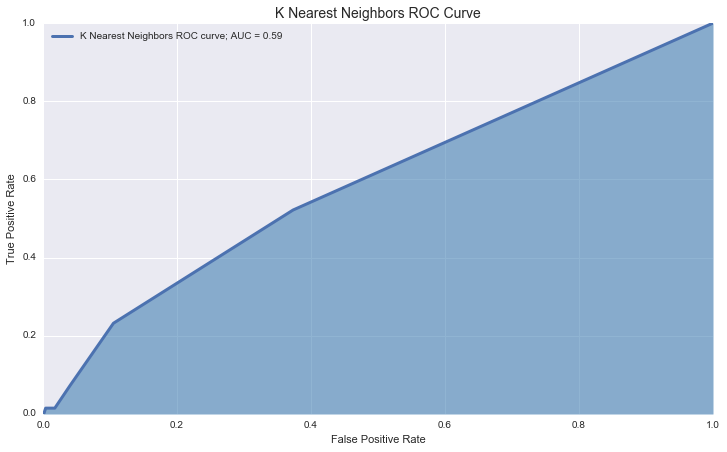

In [76]:
# Examine ROC curve and AUC.
y_hat_proba_knn = best_knn.predict_proba(X_test)
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, y_hat_proba_knn[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(knn_fpr, knn_tpr, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(knn_fpr, knn_tpr, linewidth=3, label='K Nearest Neighbors ROC curve; AUC = %0.2f' % knn_roc_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K Nearest Neighbors ROC Curve', size=14)

Our AUC score is a bit worse as well.

### Linear Discriminant Analysis ###

In [78]:
# Classify with LDA.
lda = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd', 'lsqr']}
clf_lda = GridSearchCV(lda, parameters, cv=10)
clf_lda.fit(X_train, y_train)
# Find the best of our LDA models.
best_lda = clf_lda.best_estimator_
# Make predictions based on our best model.
y_hat_lda = best_lda.predict(X_test)
# Examine confusion matrix for best LDA model.
confusion_matrix(y_test, y_hat_lda, labels=[1,0])

array([[   3,   66],
       [   9, 1087]])

Though our true negatives are down slightly, we've classified 5 positives correctly, which is an improvement.

In [79]:
# Examine other metrics.
print(classification_report(y_test, y_hat_lda))

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      1096
          1       0.25      0.04      0.07        69

avg / total       0.90      0.94      0.91      1165



Overall, our metrics are looking marginally better.

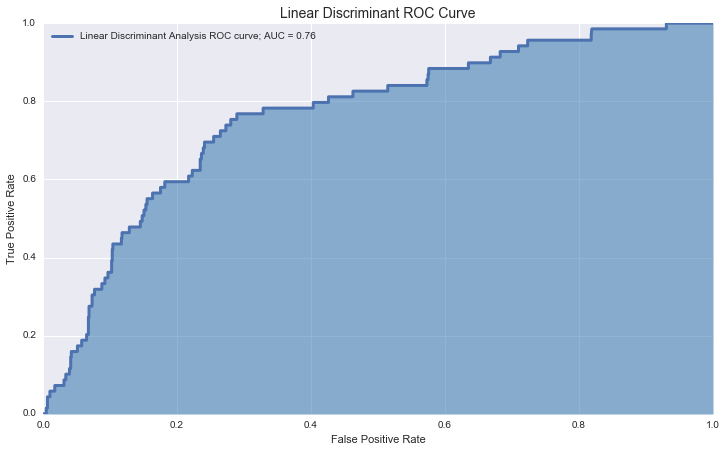

In [80]:
# Examine ROC curve and AUC.
y_hat_proba_lda = best_lda.predict_proba(X_test)
lda_fpr, lda_tpr, thresholds = roc_curve(y_test, y_hat_proba_lda[:,1])
lda_roc_auc = auc(lda_fpr, lda_tpr)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(lda_fpr, lda_tpr, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(lda_fpr, lda_tpr, linewidth=3, label='Linear Discriminant Analysis ROC curve; AUC = %0.2f' % lda_roc_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear Discriminant ROC Curve', size=14)

Our AUC score is roughly equivalent to our AUC for Logistic Regression.

### Quadratic Discriminant Analysis ###

In [81]:
# Classify with QDA.
qda = QuadraticDiscriminantAnalysis()
parameters = {'reg_param': [0.0, 0.01, 0.05, 0.1, 0.5]}
clf_qda = GridSearchCV(qda, parameters, cv=10)
clf_qda.fit(X_train, y_train)
# Find the best of our QDA models.
best_qda = clf_qda.best_estimator_
# Make predictions based on our best model.
y_hat_qda = best_qda.predict(X_test)
# Examine confusion matrix for best QDA model.
confusion_matrix(y_test, y_hat_qda, labels=[1,0])

array([[  20,   49],
       [  84, 1012]])

Again, we have more misclassifications of the negatives, but we have correctly classified 20 positives. Given that we want to ultimately predict positives, this could be an acceptable trade-off.

In [82]:
# Examine other metrics.
print(classification_report(y_test, y_hat_qda))

             precision    recall  f1-score   support

          0       0.95      0.92      0.94      1096
          1       0.19      0.29      0.23        69

avg / total       0.91      0.89      0.90      1165



While our precision is down, our recall and f1-score are up. Again, since we want to predict positives, this might be an acceptable trade-off. Our positives are our customers that will ultimately buy Caravan insurance. In this scenario, false negatives are more harmful than false positives. For false negatives, we miss the opportunity to, say, advertise to a potential customer, who may have yielded large profits had they bought the insurance. For false positives, we might spend a small amount of money advertising to someone who ultimately does not buy the insurance. By this reasoning, a higher recall is the priority, even if it means a slightly lower precision.

Still, we have plenty of room to improve our model.

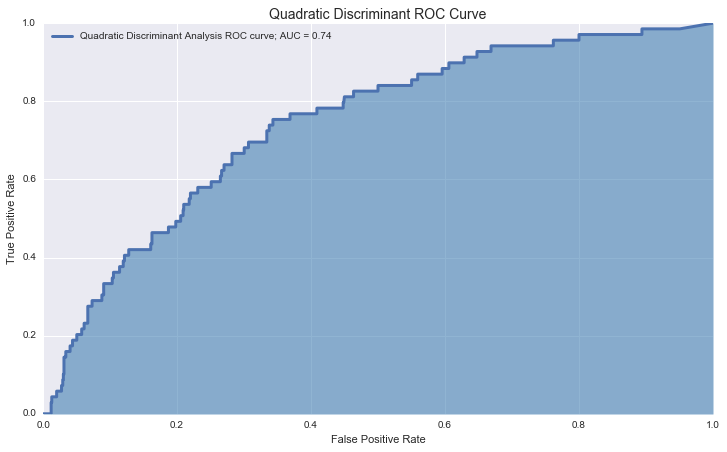

In [83]:
# Examine ROC curve and AUC.
y_hat_proba_qda = best_qda.predict_proba(X_test)
qda_fpr, qda_tpr, thresholds = roc_curve(y_test, y_hat_proba_qda[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(qda_fpr, qda_tpr, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(qda_fpr, qda_tpr, linewidth=3, label='Quadratic Discriminant Analysis ROC curve; AUC = %0.2f' % qda_roc_auc)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Quadratic Discriminant ROC Curve', size=14)

Our AUC is back down slightly.

### Normalize the Data and Run Models Again ###

So far, we have been working with un-normalized data. Now, we'll normalize our data and see if our models perform any better.

In [84]:
# Define a scaler for normalizing the data.
scaler = StandardScaler()

In [85]:
# Get scaled data.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression ####

In [86]:
# Logistic regression on scaled, ratio-preserved data.
lr_scaled = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_scaled = GridSearchCV(lr_scaled, parameters, cv=10)
clf_lr_scaled.fit(X_train_scaled, y_train)
best_lr_scaled = clf_lr_scaled.best_estimator_
y_hat_lr_scaled = best_lr_scaled.predict(X_test_scaled)
print(confusion_matrix(y_test, y_hat_lr_scaled, labels=[1,0]))

[[   0   69]
 [   1 1095]]


In [87]:
# Examine metrics.
y_hat_proba_scaled = best_lr_scaled.predict_proba(X_test_scaled)
lr_fpr_scaled, lr_tpr_scaled, thresholds_scaled = roc_curve(y_test, y_hat_proba_scaled[:,1])
lr_roc_auc_scaled = auc(lr_fpr_scaled, lr_tpr_scaled)
print('AUC: %0.2f' % lr_roc_auc_scaled)
print(classification_report(y_test, y_hat_lr_scaled))

AUC: 0.75
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1096
          1       0.00      0.00      0.00        69

avg / total       0.89      0.94      0.91      1165



This performs no better than before.

#### K Nearest Neighbors ####

In [88]:
# Classify with K-NN.
knn_scaled = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_scaled = GridSearchCV(knn_scaled, parameters, cv=10)
clf_knn_scaled.fit(X_train_scaled, y_train)
best_knn_scaled = clf_knn_scaled.best_estimator_
y_hat_knn_scaled = best_knn_scaled.predict(X_test_scaled)
confusion_matrix(y_test, y_hat_knn_scaled, labels=[1,0])

array([[   0,   69],
       [   0, 1096]])

In [89]:
# Examine metrics.
y_hat_proba_scaled = best_knn_scaled.predict_proba(X_test_scaled)
knn_fpr_scaled, knn_tpr_scaled, thresholds_scaled = roc_curve(y_test, y_hat_proba_scaled[:,1])
knn_roc_auc_scaled = auc(knn_fpr_scaled, knn_tpr_scaled)
print('AUC: %0.2f' % knn_roc_auc_scaled)
print(classification_report(y_test, y_hat_knn_scaled))

AUC: 0.61
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1096
          1       0.00      0.00      0.00        69

avg / total       0.89      0.94      0.91      1165



Aside from a likely inconsequential increase in AUC, our model performs no better than on the unscaled data.

#### Linear Discriminant Analysis ####

In [90]:
# Classify with LDA.
lda_scaled = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd', 'lsqr']}
clf_lda_scaled = GridSearchCV(lda_scaled, parameters, cv=10)
clf_lda_scaled.fit(X_train_scaled, y_train)
best_lda_scaled = clf_lda_scaled.best_estimator_
y_hat_lda_scaled = best_lda_scaled.predict(X_test_scaled)
confusion_matrix(y_test, y_hat_lda_scaled, labels=[1,0])

array([[   3,   66],
       [   9, 1087]])

In [91]:
# Examine metrics.
y_hat_proba_scaled = best_lda_scaled.predict_proba(X_test_scaled)
lda_fpr_scaled, lda_tpr_scaled, thresholds_scaled = roc_curve(y_test, y_hat_proba_scaled[:,1])
lda_roc_auc_scaled = auc(lda_fpr_scaled, lda_tpr_scaled)
print('AUC: %0.2f' % lda_roc_auc_scaled)
print(classification_report(y_test, y_hat_lda_scaled))

AUC: 0.76
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      1096
          1       0.25      0.04      0.07        69

avg / total       0.90      0.94      0.91      1165



This model performs exactly the same as on the unscaled data.

#### Quadratic Discriminant Analysis ####

In [94]:
# Classify with QDA.
qda_scaled = QuadraticDiscriminantAnalysis()
parameters = {'reg_param': [0.0, 0.01, 0.05, 0.1, 0.5]}
clf_qda_scaled = GridSearchCV(qda_scaled, parameters, cv=10)
clf_qda_scaled.fit(X_train_scaled, y_train)
# Find the best of our QDA models.
best_qda_scaled = clf_qda_scaled.best_estimator_
# Make predictions based on our best model.
y_hat_qda_scaled = best_qda_scaled.predict(X_test_scaled)
# Examine confusion matrix for best QDA model.
confusion_matrix(y_test, y_hat_qda_scaled, labels=[1,0])

array([[  17,   52],
       [  89, 1007]])

In [95]:
# Examine metrics.
y_hat_proba_scaled = best_qda_scaled.predict_proba(X_test_scaled)
qda_fpr_scaled, qda_tpr_scaled, thresholds_scaled = roc_curve(y_test, y_hat_proba_scaled[:,1])
qda_roc_auc_scaled = auc(qda_fpr_scaled, qda_tpr_scaled)
print('AUC: %0.2f' % qda_roc_auc_scaled)
print(classification_report(y_test, y_hat_qda_scaled))

AUC: 0.69
             precision    recall  f1-score   support

          0       0.95      0.92      0.93      1096
          1       0.16      0.25      0.19        69

avg / total       0.90      0.88      0.89      1165



This model performs slightly worse than it did on the unscaled data.

We have not seen much of an improvement with any of our models and so we'll have to dig deeper.

#### Support Vector Classification ####

Before we move on to manipulating our data further, let's try SVC.

In [96]:
# Classify with SVC.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_scaled = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_scaled.fit(X_train_scaled, y_train)
# Find the best of our SVC models.
best_svc_scaled = clf_svc_scaled.best_estimator_
# Make predictions based on our best model.
y_hat_svc_scaled = best_svc_scaled.predict(X_test_scaled)
# Examine confusion matrix for best SVC model.
confusion_matrix(y_test, y_hat_svc_scaled, labels=[1,0])

array([[   0,   69],
       [   0, 1096]])

In [97]:
# Examine metrics.
y_hat_proba_scaled = best_svc_scaled.predict_proba(X_test_scaled)
svc_fpr_scaled, svc_tpr_scaled, thresholds_scaled = roc_curve(y_test, y_hat_proba_scaled[:,1])
svc_roc_auc_scaled = auc(svc_fpr_scaled, svc_tpr_scaled)
print('AUC: %0.2f' % svc_roc_auc_scaled)
print(classification_report(y_test, y_hat_svc_scaled))

AUC: 0.58
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1096
          1       0.00      0.00      0.00        69

avg / total       0.89      0.94      0.91      1165



Again, we aren't getting sufficient results.

### Compensate for Class Imbalance ###

One issue that is likely contributing to poor results is that our dataset is imbalanced. Our 'positive' or '`1`' class is made up of only `348` elements, while our 'negative' or '`0`' class is made up of `5474` elements. This can result in a model that tends to more readily classify observations as negatives.

Let's try correcting for this imbalance to see if we can improve our results.

#### Under Sampling ####

In [98]:
# Remove 'excess' negatives.
undersample_df = caravan_df_raw[caravan_df_raw['Purchase'] == 1]
negatives = caravan_df_raw[caravan_df_raw['Purchase'] == 0].sample(348).sample(frac=1).reset_index(drop=True)
undersample_df = undersample_df.append(negatives)

In [99]:
# Check size.
undersample_df.shape

(696, 86)

In [100]:
# Make sure we have an even split.
undersample_df['Purchase'].value_counts()

1    348
0    348
Name: Purchase, dtype: int64

In [101]:
# Split data into X and y.
X_under = undersample_df.drop(['Purchase'], axis=1).values
y_under = undersample_df['Purchase'].factorize()[0]

In [102]:
# Normalize the data.
scaler = StandardScaler()
X_scaled_under = scaler.fit_transform(X_under)

In [103]:
# Train test split.
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_scaled_under, y_under, test_size=0.20, random_state=9)

Now let's see if any of our models perform better.

##### Logistic Regression #####

In [104]:
# Logistic regression on scaled, undersampled data.
lr_under = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_under = GridSearchCV(lr_under, parameters, cv=10)
clf_lr_under.fit(X_train_under, y_train_under)
best_lr_under = clf_lr_under.best_estimator_
y_hat_lr_under = best_lr_under.predict(X_test_under)
print(confusion_matrix(y_test_under, y_hat_lr_under, labels=[1,0]))

[[43 22]
 [33 42]]


In [105]:
# Examine metrics.
y_hat_proba_lr_under = best_lr_under.predict_proba(X_test_under)
lr_fpr_under, lr_tpr_under, thresholds_under = roc_curve(y_test_under, y_hat_proba_lr_under[:,1])
lr_roc_auc_under = auc(lr_fpr_under, lr_tpr_under)
print('AUC: %0.2f' % lr_roc_auc_under)
print(classification_report(y_test_under, y_hat_lr_under))

AUC: 0.69
             precision    recall  f1-score   support

          0       0.66      0.56      0.60        75
          1       0.57      0.66      0.61        65

avg / total       0.61      0.61      0.61       140



This model is classifying fairly close to chance. Not what we want.

##### K Nearest Neighbors #####

In [106]:
# K-NN on scaled, undersampled data.
knn_under = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_under = GridSearchCV(knn_under, parameters, cv=10)
clf_knn_under.fit(X_train_under, y_train_under)
best_knn_under = clf_knn_under.best_estimator_
y_hat_knn_under = best_knn_under.predict(X_test_under)
confusion_matrix(y_test_under, y_hat_knn_under, labels=[1,0])

array([[41, 24],
       [23, 52]])

In [107]:
# Examine metrics.
y_hat_proba_knn_under = best_knn_under.predict_proba(X_test_under)
knn_fpr_under, knn_tpr_under, thresholds_under = roc_curve(y_test_under, y_hat_proba_knn_under[:,1])
knn_roc_auc_under = auc(knn_fpr_under, knn_tpr_under)
print('AUC: %0.2f' % knn_roc_auc_under)
print(classification_report(y_test_under, y_hat_knn_under))

AUC: 0.73
             precision    recall  f1-score   support

          0       0.68      0.69      0.69        75
          1       0.64      0.63      0.64        65

avg / total       0.66      0.66      0.66       140



Slightly better than Logistic Regression. Moving in the right direction, but still not acceptable.

##### LDA #####

In [108]:
# LDA on scaled, undersampled data.
lda_under = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd', 'lsqr']}
clf_lda_under = GridSearchCV(lda_under, parameters, cv=10)
clf_lda_under.fit(X_train_under, y_train_under)
best_lda_under = clf_lda_under.best_estimator_
y_hat_lda_under = best_lda_under.predict(X_test_under)
confusion_matrix(y_test_under, y_hat_lda_under, labels=[1,0])

array([[42, 23],
       [31, 44]])

In [109]:
# Examine metrics.
y_hat_proba_under = best_lda_under.predict_proba(X_test_under)
lda_fpr_under, lda_tpr_under, thresholds_under = roc_curve(y_test_under, y_hat_proba_under[:,1])
lda_roc_auc_under = auc(lda_fpr_under, lda_tpr_under)
print('AUC: %0.2f' % lda_roc_auc_under)
print(classification_report(y_test_under, y_hat_lda_under))

AUC: 0.68
             precision    recall  f1-score   support

          0       0.66      0.59      0.62        75
          1       0.58      0.65      0.61        65

avg / total       0.62      0.61      0.61       140



##### QDA #####

In [110]:
# QDA on scaled, undersampled data.
qda_under = QuadraticDiscriminantAnalysis()
parameters = {'reg_param': [0.0, 0.01, 0.05, 0.1, 0.5]}
clf_qda_under = GridSearchCV(qda_under, parameters, cv=10)
clf_qda_under.fit(X_train_under, y_train_under)
best_qda_under = clf_qda_under.best_estimator_
y_hat_qda_under = best_qda_under.predict(X_test_under)
confusion_matrix(y_test_under, y_hat_qda_under, labels=[1,0])

array([[55, 10],
       [49, 26]])

In [111]:
# Examine metrics.
y_hat_proba_under = best_qda_under.predict_proba(X_test_under)
qda_fpr_under, qda_tpr_under, thresholds_under = roc_curve(y_test_under, y_hat_proba_under[:,1])
qda_roc_auc_under = auc(qda_fpr_under, qda_tpr_under)
print('AUC: %0.2f' % qda_roc_auc_under)
print(classification_report(y_test_under, y_hat_qda_under))

AUC: 0.69
             precision    recall  f1-score   support

          0       0.72      0.35      0.47        75
          1       0.53      0.85      0.65        65

avg / total       0.63      0.58      0.55       140



##### SVC #####

In [112]:
# SVC on scaled, undersampled data.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_under = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_under.fit(X_train_under, y_train_under)
best_svc_under = clf_svc_under.best_estimator_
y_hat_svc_under = best_svc_under.predict(X_test_under)
confusion_matrix(y_test_under, y_hat_svc_under, labels=[1,0])

array([[45, 20],
       [31, 44]])

In [113]:
# Examine metrics.
y_hat_proba_under = best_svc_under.predict_proba(X_test_under)
svc_fpr_under, svc_tpr_under, thresholds_under = roc_curve(y_test_under, y_hat_proba_under[:,1])
svc_roc_auc_under = auc(svc_fpr_under, svc_tpr_under)
print('AUC: %0.2f' % svc_roc_auc_under)
print(classification_report(y_test_under, y_hat_svc_under))

AUC: 0.68
             precision    recall  f1-score   support

          0       0.69      0.59      0.63        75
          1       0.59      0.69      0.64        65

avg / total       0.64      0.64      0.64       140



We are not getting very good results with under sampling.

#### Over Sampling ####

In our original data, we have a roughly `1:15` ratio of positives to negatives. Let's 'oversample' the rpositives to get a smaller ratio, say closer to `1:2`.

In [114]:
# Multiply the number of positives by 6. We'll then add to the original database for 7x total positives.
positives = caravan_df_raw[caravan_df_raw['Purchase'] == 1]
for _ in range(4):
    positives = positives.append(caravan_df_raw[caravan_df_raw['Purchase'] == 1])

In [115]:
# Check size of positives.
positives.shape

(1740, 86)

In [116]:
# Examine label values.
positives['Purchase'].value_counts()

1    1740
Name: Purchase, dtype: int64

In [117]:
# Append negatives.
oversample_df = caravan_df_raw.append(positives).sample(frac=1).reset_index(drop=True)

In [118]:
# Check size of new dataset.
oversample_df.shape

(7562, 86)

In [119]:
# Check ratio of label values.
oversample_df['Purchase'].value_counts()

0    5474
1    2088
Name: Purchase, dtype: int64

In [120]:
# Split data into X and y.
X_over = oversample_df.drop(['Purchase'], axis=1).values
y_over = oversample_df['Purchase'].factorize()[0]

In [121]:
# Normalize the data.
scaler = StandardScaler()
X_scaled_over = scaler.fit_transform(X_over)

In [122]:
# Train test split.
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_scaled_over, y_over, test_size=0.20, random_state=9)

Let's evaluate our models again.

##### Logistic Regression #####

In [123]:
# Logistic regression on scaled, oversampled data.
lr_over = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_over = GridSearchCV(lr_over, parameters, cv=10)
clf_lr_over.fit(X_train_over, y_train_over)
best_lr_over = clf_lr_over.best_estimator_
y_hat_lr_over = best_lr_over.predict(X_test_over)
print(confusion_matrix(y_test_over, y_hat_lr_over, labels=[1,0]))

[[152 278]
 [ 86 997]]


In [124]:
# Examine metrics.
y_hat_proba_lr_over = best_lr_over.predict_proba(X_test_over)
lr_fpr_over, lr_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_lr_over[:,1])
lr_roc_auc_over = auc(lr_fpr_over, lr_tpr_over)
print('AUC: %0.2f' % lr_roc_auc_over)
print(classification_report(y_test_over, y_hat_lr_over))

AUC: 0.78
             precision    recall  f1-score   support

          0       0.78      0.92      0.85      1083
          1       0.64      0.35      0.46       430

avg / total       0.74      0.76      0.73      1513



This is a significant improvement! Not only is AUC back up but we are getting better precision and recall on our positive class. We've also correctly classified `152` positives. Our best yet! But we can do better.

##### K Nearest Neighbors #####

In [125]:
# K-NN on scaled, oversampled data.
knn_over = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_over = GridSearchCV(knn_over, parameters, cv=10)
clf_knn_over.fit(X_train_over, y_train_over)
best_knn_over = clf_knn_over.best_estimator_
y_hat_knn_over = best_knn_over.predict(X_test_over)
confusion_matrix(y_test_over, y_hat_knn_over, labels=[1,0])

array([[414,  16],
       [ 84, 999]])

In [126]:
# Examine metrics.
y_hat_proba_knn_over = best_knn_over.predict_proba(X_test_over)
knn_fpr_over, knn_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_knn_over[:,1])
knn_roc_auc_over = auc(knn_fpr_over, knn_tpr_over)
print('AUC: %0.2f' % knn_roc_auc_over)
print(classification_report(y_test_over, y_hat_knn_over))

AUC: 0.96
             precision    recall  f1-score   support

          0       0.98      0.92      0.95      1083
          1       0.83      0.96      0.89       430

avg / total       0.94      0.93      0.94      1513



Wow! This is looking pretty good. Let's take a look at the ROC curve.

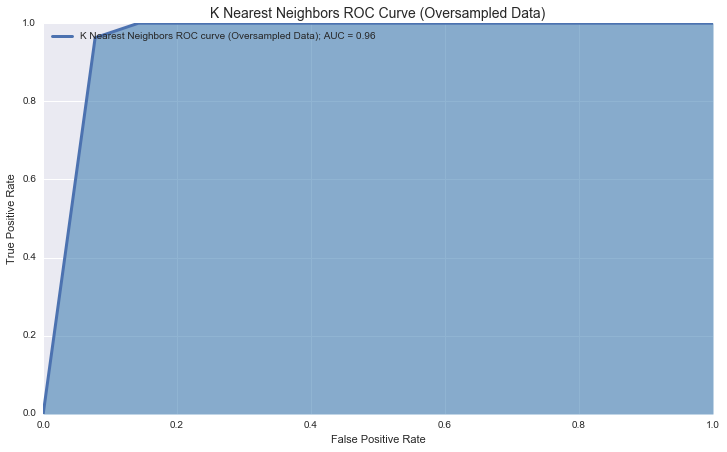

In [127]:
# Examine ROC curve and AUC.
y_hat_proba_knn_over = best_knn_over.predict_proba(X_test_over)
knn_fpr_over, knn_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_knn_over[:,1])
knn_roc_auc_over = auc(knn_fpr_over, knn_tpr_over)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(knn_fpr_over, knn_tpr_over, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(knn_fpr_over, knn_tpr_over, linewidth=3, label='K Nearest Neighbors ROC curve (Oversampled Data); AUC = %0.2f' % knn_roc_auc_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K Nearest Neighbors ROC Curve (Oversampled Data)', size=14)

##### LDA #####

In [128]:
# LDA on scaled, oversampled data.
lda_over = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd', 'lsqr']}
clf_lda_over = GridSearchCV(lda_over, parameters, cv=10)
clf_lda_over.fit(X_train_over, y_train_over)
best_lda_over = clf_lda_over.best_estimator_
y_hat_lda_over = best_lda_over.predict(X_test_over)
confusion_matrix(y_test_over, y_hat_lda_over, labels=[1,0])

array([[159, 271],
       [ 89, 994]])

In [136]:
# Examine metrics.
y_hat_proba_lda_over = best_lda_over.predict_proba(X_test_over)
lda_fpr_over, lda_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_lda_over[:,1])
lda_roc_auc_over = auc(lda_fpr_over, lda_tpr_over)
print('AUC: %0.2f' % lda_roc_auc_over)
print(classification_report(y_test_over, y_hat_lda_over))

AUC: 0.78
             precision    recall  f1-score   support

          0       0.79      0.92      0.85      1083
          1       0.64      0.37      0.47       430

avg / total       0.74      0.76      0.74      1513



##### QDA #####

In [130]:
# QDA on scaled, oversampled data.
qda_over = QuadraticDiscriminantAnalysis()
parameters = {'reg_param': [0.0, 0.01, 0.05, 0.1, 0.5]}
clf_qda_over = GridSearchCV(qda_over, parameters, cv=10)
clf_qda_over.fit(X_train_over, y_train_over)
best_qda_over = clf_qda_over.best_estimator_
y_hat_qda_over = best_qda_over.predict(X_test_over)
confusion_matrix(y_test_over, y_hat_qda_over, labels=[1,0])

array([[282, 148],
       [259, 824]])

In [137]:
# Examine metrics.
y_hat_proba_qda_over = best_qda_over.predict_proba(X_test_over)
qda_fpr_over, qda_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_qda_over[:,1])
qda_roc_auc_over = auc(qda_fpr_over, qda_tpr_over)
print('AUC: %0.2f' % qda_roc_auc_over)
print(classification_report(y_test_over, y_hat_qda_over))

AUC: 0.79
             precision    recall  f1-score   support

          0       0.85      0.76      0.80      1083
          1       0.52      0.66      0.58       430

avg / total       0.75      0.73      0.74      1513



##### SVC #####

In [134]:
# SVC on scaled, oversampled data.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_over = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_over.fit(X_train_over, y_train_over)
best_svc_over = clf_svc_over.best_estimator_
y_hat_svc_over = best_svc_over.predict(X_test_over)
confusion_matrix(y_test_over, y_hat_svc_over, labels=[1,0])

array([[ 280,  150],
       [  70, 1013]])

In [138]:
# Examine metrics.
y_hat_proba_svc_over = best_svc_over.predict_proba(X_test_over)
svc_fpr_over, svc_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_svc_over[:,1])
svc_roc_auc_over = auc(svc_fpr_over, svc_tpr_over)
print('AUC: %0.2f' % svc_roc_auc_over)
print(classification_report(y_test_over, y_hat_svc_over))

AUC: 0.91
             precision    recall  f1-score   support

          0       0.87      0.94      0.90      1083
          1       0.80      0.65      0.72       430

avg / total       0.85      0.85      0.85      1513



Not bad either! This model takes some time to run but we're getting some pretty nice precision numbers on the positive class and our AUC is very good.

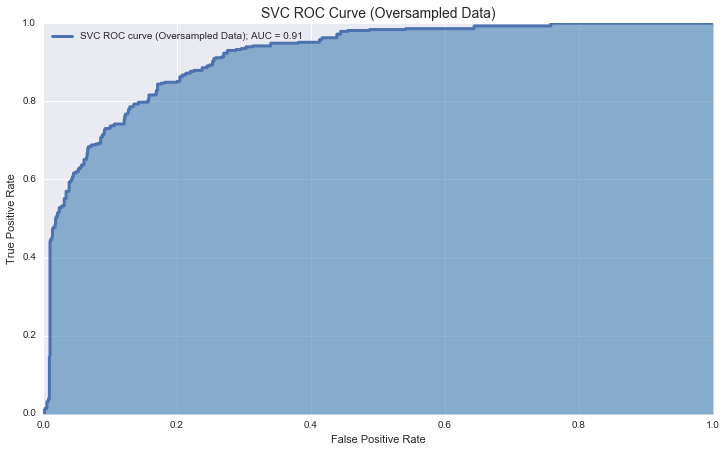

In [139]:
# Examine ROC curve and AUC.
y_hat_proba_svc_over = best_svc_over.predict_proba(X_test_over)
svc_fpr_over, svc_tpr_over, thresholds_over = roc_curve(y_test_over, y_hat_proba_svc_over[:,1])
svc_roc_auc_over = auc(svc_fpr_over, svc_tpr_over)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(svc_fpr_over, svc_tpr_over, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(svc_fpr_over, svc_tpr_over, linewidth=3, label='SVC ROC curve (Oversampled Data); AUC = %0.2f' % svc_roc_auc_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve (Oversampled Data)', size=14)

#### SMOTE ####

Next, let's try the `SMOTE` method for oversampling to see how our results compare.

In [140]:
df_3 = caravan_df_raw.sample(frac=1).reset_index(drop=True)

In [141]:
# Split data into X and y.
X_3 = df_3.drop(['Purchase'], axis=1).values
y_3 = df_3['Purchase'].factorize()[0]

In [142]:
# Normalize the data.
scaler = StandardScaler()
X_scaled3 = scaler.fit_transform(X_3)

In [143]:
# Train test split.
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_scaled3, y_3, test_size=0.20, random_state=9)

In [144]:
# Apply SMOTE.
sm = SMOTE(random_state=9)
smote_X, smote_y = sm.fit_sample(X_train3, y_train3)

##### Logistic Regression #####

In [145]:
# Logistic regression with SMOTE.
lr_smote = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_smote = GridSearchCV(lr_smote, parameters, cv=10)
clf_lr_smote.fit(smote_X, smote_y)
best_lr_smote = clf_lr_smote.best_estimator_
y_hat_lr_smote = best_lr_smote.predict(X_test3)
print(confusion_matrix(y_test3, y_hat_lr_smote, labels=[1,0]))

[[ 39  20]
 [329 777]]


In [146]:
# Examine metrics.
y_hat_proba_lr_smote = best_lr_smote.predict_proba(X_test3)
lr_fpr_smote, lr_tpr_smote, thresholds_smote = roc_curve(y_test3, y_hat_proba_lr_smote[:,1])
lr_roc_auc_smote = auc(lr_fpr_smote, lr_tpr_smote)
print('AUC: %0.2f' % lr_roc_auc_smote)
print(classification_report(y_test3, y_hat_lr_smote))

AUC: 0.73
             precision    recall  f1-score   support

          0       0.97      0.70      0.82      1106
          1       0.11      0.66      0.18        59

avg / total       0.93      0.70      0.78      1165



With `SMOTE` alone, we've taken a step backwards.

##### K-NN #####

In [147]:
# K-NN with SMOTE.
knn_smote = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_smote = GridSearchCV(knn_smote, parameters, cv=10)
clf_knn_smote.fit(smote_X, smote_y)
best_knn_smote = clf_knn_smote.best_estimator_
y_hat_knn_smote = best_knn_smote.predict(X_test3)
confusion_matrix(y_test3, y_hat_knn_smote, labels=[1,0])

array([[  17,   42],
       [ 106, 1000]])

In [148]:
# Examine metrics.
y_hat_proba_knn_smote = best_knn_smote.predict_proba(X_test3)
knn_fpr_smote, knn_tpr_smote, thresholds_smote = roc_curve(y_test3, y_hat_proba_knn_smote[:,1])
knn_roc_auc_smote = auc(knn_fpr_smote, knn_tpr_smote)
print('AUC: %0.2f' % knn_roc_auc_smote)
print(classification_report(y_test3, y_hat_knn_smote))

AUC: 0.64
             precision    recall  f1-score   support

          0       0.96      0.90      0.93      1106
          1       0.14      0.29      0.19        59

avg / total       0.92      0.87      0.89      1165



The same goes for K-Nearest Neighbors. This looks like a losing battle. However, before we completely abandon `SMOTE`, let's try it on our other models.

##### LDA #####

In [149]:
# LDA with SMOTE.
lda_smote = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd', 'lsqr']}
clf_lda_smote = GridSearchCV(lda_smote, parameters, cv=10)
clf_lda_smote.fit(smote_X, smote_y)
best_lda_smote = clf_lda_smote.best_estimator_
y_hat_lda_smote = best_lda_smote.predict(X_test3)
confusion_matrix(y_test3, y_hat_lda_smote, labels=[1,0])

array([[ 39,  20],
       [342, 764]])

In [150]:
# Examine metrics.
y_hat_proba_smote = best_lda_smote.predict_proba(X_test3)
lda_fpr_smote, lda_tpr_smote, thresholds_smote = roc_curve(y_test3, y_hat_proba_smote[:,1])
lda_roc_auc_smote = auc(lda_fpr_smote, lda_tpr_smote)
print('AUC: %0.2f' % lda_roc_auc_smote)
print(classification_report(y_test3, y_hat_lda_smote))

AUC: 0.74
             precision    recall  f1-score   support

          0       0.97      0.69      0.81      1106
          1       0.10      0.66      0.18        59

avg / total       0.93      0.69      0.78      1165



##### QDA #####

In [151]:
# QDA with SMOTE.
qda_smote = QuadraticDiscriminantAnalysis()
parameters = {'reg_param': [0.0, 0.01, 0.05, 0.1, 0.5]}
clf_qda_smote = GridSearchCV(qda_smote, parameters, cv=10)
clf_qda_smote.fit(smote_X, smote_y)
best_qda_smote = clf_qda_smote.best_estimator_
y_hat_qda_smote = best_qda_smote.predict(X_test3)
confusion_matrix(y_test3, y_hat_qda_smote, labels=[1,0])

array([[ 43,  16],
       [586, 520]])

In [152]:
# Examine metrics.
y_hat_proba_smote = best_qda_smote.predict_proba(X_test3)
qda_fpr_smote, qda_tpr_smote, thresholds_smote = roc_curve(y_test3, y_hat_proba_smote[:,1])
qda_roc_auc_smote = auc(qda_fpr_smote, qda_tpr_smote)
print('AUC: %0.2f' % qda_roc_auc_smote)
print(classification_report(y_test3, y_hat_qda_smote))

AUC: 0.66
             precision    recall  f1-score   support

          0       0.97      0.47      0.63      1106
          1       0.07      0.73      0.12        59

avg / total       0.92      0.48      0.61      1165



##### SVC #####

In [153]:
# Classify with SVC.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_smote = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_smote.fit(smote_X, smote_y)
best_svc_smote = clf_svc_smote.best_estimator_
y_hat_svc_smote = best_svc_smote.predict(X_test3)
confusion_matrix(y_test3, y_hat_svc_smote, labels=[1,0])

array([[ 20,  39],
       [134, 972]])

In [166]:
# Examine metrics.
y_hat_proba_svc_smote = best_svc_smote.predict_proba(X_test3)
svc_fpr_smote, svc_tpr_smote, thresholds_smote = roc_curve(y_test3, y_hat_proba_svc_smote[:,1])
svc_roc_auc_smote = auc(svc_fpr_smote, svc_tpr_smote)
print('AUC: %0.2f' % svc_roc_auc_smote)
print(classification_report(y_test3, y_hat_svc_smote))

AUC: 0.67
             precision    recall  f1-score   support

          0       0.96      0.88      0.92      1106
          1       0.13      0.34      0.19        59

avg / total       0.92      0.85      0.88      1165



Let's see if we can get better results using `SMOTE` in conjunction with `PCA`.

### Principal Component Analysis with SMOTE ###

In [155]:
# Create a PCA object.
pca = PCA(n_components=22)

In [156]:
# Apply to smote_X.
pca.fit_transform(X_train3)
pca_smote_X_train = pca.transform(smote_X)
pca_smote_X_test = pca.transform(X_test3)

##### Logistic Regression ######

In [157]:
# Logistic regression with PCA and SMOTE.
lr_pca_smote = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_pca_smote = GridSearchCV(lr_pca_smote, parameters, cv=10)
clf_lr_pca_smote.fit(pca_smote_X_train, smote_y)
best_lr_pca_smote = clf_lr_pca_smote.best_estimator_
y_hat_lr_pca_smote = best_lr_pca_smote.predict(pca_smote_X_test)
print(confusion_matrix(y_test3, y_hat_lr_pca_smote, labels=[1,0]))

[[ 40  19]
 [367 739]]


In [158]:
# Examine metrics.
y_hat_proba_lr_pca_smote = best_lr_pca_smote.predict_proba(pca_smote_X_test)
lr_fpr_pca_smote, lr_tpr_pca_smote, thresholds_pca_smote = roc_curve(y_test3, y_hat_proba_lr_pca_smote[:,1])
lr_roc_auc_pca_smote = auc(lr_fpr_pca_smote, lr_tpr_pca_smote)
print('AUC: %0.2f' % lr_roc_auc_pca_smote)
print(classification_report(y_test3, y_hat_lr_pca_smote))

AUC: 0.73
             precision    recall  f1-score   support

          0       0.97      0.67      0.79      1106
          1       0.10      0.68      0.17        59

avg / total       0.93      0.67      0.76      1165



##### K-NN #####

In [159]:
# K-NN with PCA and SMOTE.
knn_pca_smote = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_pca_smote = GridSearchCV(knn_pca_smote, parameters, cv=10)
clf_knn_pca_smote.fit(pca_smote_X_train, smote_y)
best_knn_pca_smote = clf_knn_pca_smote.best_estimator_
y_hat_knn_pca_smote = best_knn_pca_smote.predict(pca_smote_X_test)
confusion_matrix(y_test3, y_hat_knn_pca_smote, labels=[1,0])

array([[  12,   47],
       [ 105, 1001]])

In [160]:
# Examine metrics.
y_hat_proba_knn_pca_smote = best_knn_pca_smote.predict_proba(pca_smote_X_test)
knn_fpr_pca_smote, knn_tpr_pca_smote, thresholds_pca_smote = roc_curve(y_test3, y_hat_proba_knn_pca_smote[:,1])
knn_roc_auc_pca_smote = auc(knn_fpr_pca_smote, knn_tpr_pca_smote)
print('AUC: %0.2f' % knn_roc_auc_pca_smote)
print(classification_report(y_test3, y_hat_knn_pca_smote))

AUC: 0.65
             precision    recall  f1-score   support

          0       0.96      0.91      0.93      1106
          1       0.10      0.20      0.14        59

avg / total       0.91      0.87      0.89      1165



Depending on the number of components we use for `PCA`, our models perform differently, but it seems that overall they aren't performing quite as well as they were under straight oversampling.

##### LDA #####

In [161]:
# LDA with PCA and SMOTE.
lda_pca_smote = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd', 'lsqr']}
clf_lda_pca_smote = GridSearchCV(lda_pca_smote, parameters, cv=10)
clf_lda_pca_smote.fit(pca_smote_X_train, smote_y)
best_lda_pca_smote = clf_lda_pca_smote.best_estimator_
y_hat_lda_pca_smote = best_lda_pca_smote.predict(pca_smote_X_test)
confusion_matrix(y_test3, y_hat_lda_pca_smote, labels=[1,0])

array([[ 42,  17],
       [372, 734]])

In [162]:
# Examine metrics.
y_hat_proba_pca_smote = best_lda_pca_smote.predict_proba(pca_smote_X_test)
lda_fpr_pca_smote, lda_tpr_pca_smote, thresholds_pca_smote = roc_curve(y_test3, y_hat_proba_pca_smote[:,1])
lda_roc_auc_pca_smote = auc(lda_fpr_pca_smote, lda_tpr_pca_smote)
print('AUC: %0.2f' % lda_roc_auc_pca_smote)
print(classification_report(y_test3, y_hat_lda_pca_smote))

AUC: 0.74
             precision    recall  f1-score   support

          0       0.98      0.66      0.79      1106
          1       0.10      0.71      0.18        59

avg / total       0.93      0.67      0.76      1165



##### QDA #####

In [163]:
# QDA with PCA and SMOTE.
qda_pca_smote = QuadraticDiscriminantAnalysis()
parameters = {'reg_param': [0.0, 0.01, 0.05, 0.1, 0.5]}
clf_qda_pca_smote = GridSearchCV(qda_pca_smote, parameters, cv=10)
clf_qda_pca_smote.fit(pca_smote_X_train, smote_y)
best_qda_pca_smote = clf_qda_pca_smote.best_estimator_
y_hat_qda_pca_smote = best_qda_pca_smote.predict(pca_smote_X_test)
confusion_matrix(y_test3, y_hat_qda_pca_smote, labels=[1,0])

array([[ 40,  19],
       [462, 644]])

In [164]:
# Examine metrics.
y_hat_proba_pca_smote = best_qda_pca_smote.predict_proba(pca_smote_X_test)
qda_fpr_pca_smote, qda_tpr_pca_smote, thresholds_pca_smote = roc_curve(y_test3, y_hat_proba_pca_smote[:,1])
qda_roc_auc_pca_smote = auc(qda_fpr_pca_smote, qda_tpr_pca_smote)
print('AUC: %0.2f' % qda_roc_auc_pca_smote)
print(classification_report(y_test3, y_hat_qda_pca_smote))

AUC: 0.68
             precision    recall  f1-score   support

          0       0.97      0.58      0.73      1106
          1       0.08      0.68      0.14        59

avg / total       0.93      0.59      0.70      1165



##### SVC #####

In [165]:
# Classify with SVC.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_pca_smote = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_pca_smote.fit(pca_smote_X_train, smote_y)
best_svc_pca_smote = clf_svc_pca_smote.best_estimator_
y_hat_svc_pca_smote = best_svc_pca_smote.predict(pca_smote_X_test)
confusion_matrix(y_test3, y_hat_svc_pca_smote, labels=[1,0])

array([[ 25,  34],
       [191, 915]])

In [168]:
# Examine metrics.
y_hat_proba_svc_pca_smote = best_svc_pca_smote.predict_proba(pca_smote_X_test)
svc_fpr_pca_smote, svc_tpr_pca_smote, thresholds_pca_smote = roc_curve(y_test3, y_hat_proba_svc_pca_smote[:,1])
svc_roc_auc_pca_smote = auc(svc_fpr_pca_smote, svc_tpr_pca_smote)
print('AUC: %0.2f' % svc_roc_auc_pca_smote)
print(classification_report(y_test3, y_hat_svc_pca_smote))

AUC: 0.70
             precision    recall  f1-score   support

          0       0.96      0.83      0.89      1106
          1       0.12      0.42      0.18        59

avg / total       0.92      0.81      0.85      1165



We're doing better with `PCA` + `SMOTE` than with `SMOTE` alone, but we still did better on straight over sampling.

Next, let's try manipulating our dataset a bit more before modeling.

### Removing Features with Less 'Signal' ###

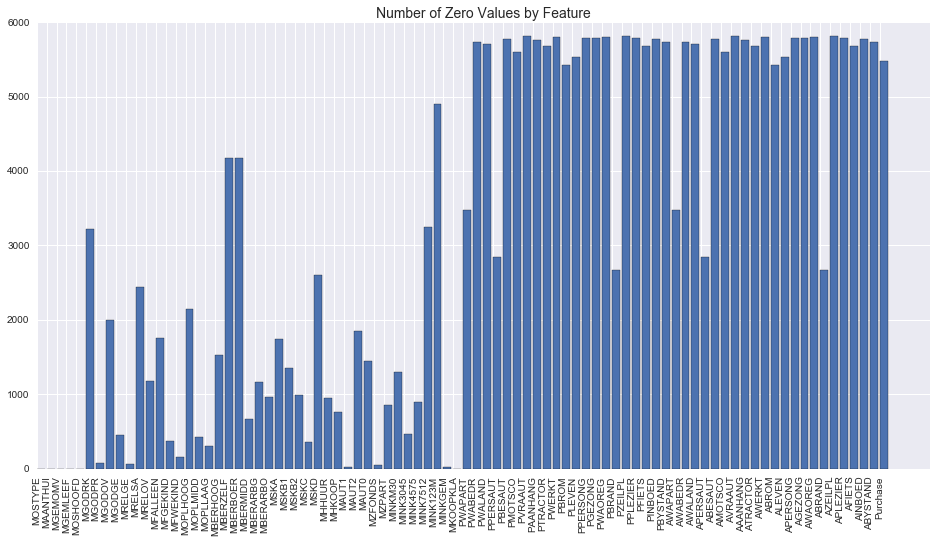

In [169]:
# Recall which features have mostly 0 values.
num_zeros = []
for i in range(0, len(caravan_df_raw.columns)):
    num_nonzero = len(caravan_df_raw.iloc[:,i].nonzero()[0])
    num_zeros.append(caravan_df_raw.shape[0] - num_nonzero)
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
objects = caravan_df_raw.columns
x_pos = np.arange(len(objects))
ax1 = plt.bar(x_pos, num_zeros)
plt.xticks(x_pos, objects)
plt.xticks(rotation=90);
plt.title('Number of Zero Values by Feature', size=14)

Let's try removing every feature that has over 5000 `0s`.

In [171]:
# Drop the columns.
signal_df = caravan_df_raw.drop(['PWABEDR', 'PWALAND', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG', 'PTRACTOR',
                                 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG', 'PZEILPL', 'PPLEZIER',
                                  'PFIETS', 'PINBOED', 'PBYSTAND', 'AWABEDR', 'AWALAND', 'ABESAUT', 'AMOTSCO', 'AVRAAUT',
                                  'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG',
                                  'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND'], axis=1)

In [172]:
# Check that columns were dropped.
signal_df.shape

(5822, 50)

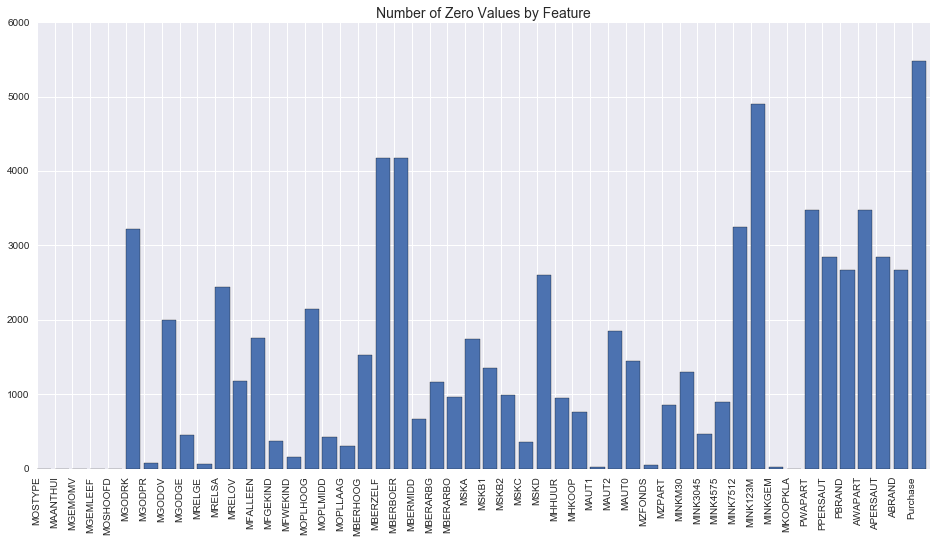

In [173]:
# Look at 0 values for signal_df.
num_zeros = []
for i in range(0, len(signal_df.columns)):
    num_nonzero = len(signal_df.iloc[:,i].nonzero()[0])
    num_zeros.append(signal_df.shape[0] - num_nonzero)
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
objects = signal_df.columns
x_pos = np.arange(len(objects))
ax1 = plt.bar(x_pos, num_zeros)
plt.xticks(x_pos, objects)
plt.xticks(rotation=90);
plt.title('Number of Zero Values by Feature', size=14)

This looks much better. Let's see if this helps our various models' performance.

#### Ratio-Preserved Training and Test Data ####

In [174]:
# Shuffle the data randomly. Random seed already set above.
shuffled_signal = signal_df.sample(frac=1).reset_index(drop=True)

In [175]:
# Get ratio of 1s to 0s.
ratio_ones = shuffled_signal['Purchase'].value_counts()[1]/(shuffled_signal['Purchase'].value_counts()[0] + 
                                                        shuffled_signal['Purchase'].value_counts()[1])

In [176]:
# Get size of training and test sets.
train_size = int(shuffled_signal.shape[0]*.80)
test_size = shuffled_signal.shape[0]-train_size
print('Training set size: %i' % train_size)
print('Test set size: %i' % test_size)

Training set size: 4657
Test set size: 1165


In [177]:
# Get number of 1s and 0s in Purchase column for training set.
train_num_ones = math.ceil(train_size*(ratio_ones))
train_num_zeros = train_size-train_num_ones
print('Training set 1s: %i' % train_num_ones)
print('Training set 0s: %i' % train_num_zeros)

Training set 1s: 279
Training set 0s: 4378


In [178]:
# Get number of 1s and 0s in Purchase column for test set.
test_num_ones = int(test_size*(ratio_ones))
test_num_zeros = test_size-test_num_ones
print('Test set 1s: %i' % test_num_ones)
print('Test set 0s: %i' % test_num_zeros)

Test set 1s: 69
Test set 0s: 1096


In [179]:
# Split shuffled data according to the proper ratios.
test_signal = shuffled_signal[shuffled_signal['Purchase'] == 1][:test_num_ones]
train_signal = shuffled_signal[shuffled_signal['Purchase'] == 1][test_num_ones:]
test_signal = test_signal.append(shuffled_signal[shuffled_signal['Purchase'] == 0][:test_num_zeros])
train_signal = test_signal.append(shuffled_signal[shuffled_signal['Purchase'] == 0][test_num_zeros:])

In [180]:
# Verify that the split went according to plan.
print(test_signal['Purchase'].value_counts())
print(train_signal['Purchase'].value_counts())

0    1096
1      69
Name: Purchase, dtype: int64
0    5474
1      69
Name: Purchase, dtype: int64


In [181]:
# Reset training and test dataset indexes.
train_signal = train_signal.sample(frac=1).reset_index(drop=True)
test_signal = test_signal.sample(frac=1).reset_index(drop=True)

In [182]:
# Split training set into features X and label y.
y_train_signal = train_signal['Purchase']
X_train_signal = train_signal.drop(['Purchase'], axis=1)

In [183]:
# Split test set into features X and label y.
y_test_signal = test_signal['Purchase']
X_test_signal = test_signal.drop(['Purchase'], axis=1)

In [184]:
# Define a scaler for normalizing the data.
scaler = StandardScaler()

In [185]:
# Get scaled data.
X_train_signal_scaled = scaler.fit_transform(X_train_signal)
X_test_signal_scaled = scaler.transform(X_test_signal)

##### Logistic Regression #####

In [186]:
# Logistic regression with fewer features.
lr_signal = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_signal = GridSearchCV(lr_signal, parameters, cv=10)
clf_lr_signal.fit(X_train_signal_scaled, y_train_signal)
best_lr_signal = clf_lr_signal.best_estimator_
y_hat_lr_signal = best_lr_signal.predict(X_test_signal_scaled)
print(confusion_matrix(y_test_signal, y_hat_lr_signal, labels=[1,0]))

[[   0   69]
 [   0 1096]]


In [187]:
# Examine metrics.
y_hat_proba_lr_signal = best_lr_signal.predict_proba(X_test_signal_scaled)
lr_fpr_signal, lr_tpr_signal, thresholds_signal = roc_curve(y_test_signal, y_hat_proba_lr_signal[:,1])
lr_roc_auc_signal = auc(lr_fpr_signal, lr_tpr_signal)
print('AUC: %0.2f' % lr_roc_auc_signal)
print(classification_report(y_test_signal, y_hat_lr_signal))

AUC: 0.83
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1096
          1       0.00      0.00      0.00        69

avg / total       0.89      0.94      0.91      1165



Our confusion matrix is bad, as are most of our metrics. AUC, though, is relatively high.

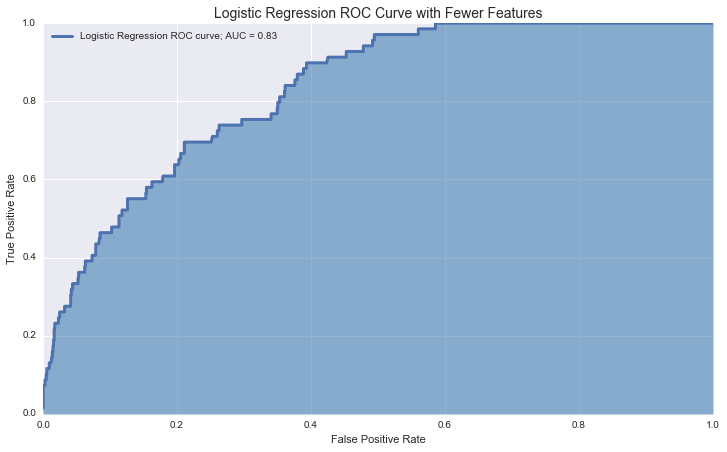

In [188]:
# Plot ROC curve and AUC for our logistic regression model.
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(lr_fpr_signal, lr_tpr_signal, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(lr_fpr_signal, lr_tpr_signal, linewidth=3, label='Logistic Regression ROC curve; AUC = %0.2f' % lr_roc_auc_signal)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve with Fewer Features', size=14)

##### K-NN #####

In [198]:
# K-NN with fewer features.
knn_signal = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_signal = GridSearchCV(knn_signal, parameters, cv=10)
clf_knn_signal.fit(X_train_signal_scaled, y_train_signal)
best_knn_signal = clf_knn_signal.best_estimator_
y_hat_knn_signal = best_knn_signal.predict(X_test_signal_scaled)
confusion_matrix(y_test_signal, y_hat_knn_signal, labels=[1,0])

array([[   0,   69],
       [   0, 1096]])

In [199]:
# Examine metrics.
y_hat_proba_knn_signal = best_knn_signal.predict_proba(X_test_signal_scaled)
knn_fpr_signal, knn_tpr_signal, thresholds_signal = roc_curve(y_test_signal, y_hat_proba_knn_signal[:,1])
knn_roc_auc_signal = auc(knn_fpr_signal, knn_tpr_signal)
print('AUC: %0.2f' % knn_roc_auc_signal)
print(classification_report(y_test_signal, y_hat_knn_signal))

AUC: 0.97
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1096
          1       0.00      0.00      0.00        69

avg / total       0.89      0.94      0.91      1165



Once again, we have a fantastic AUC score, but our metrics for positive classifications are awful. This model isn't performing as well as the AUC would have us believe.

##### LDA #####

In [207]:
# LDA with fewer features.
lda_signal = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd', 'lsqr']}
clf_lda_signal = GridSearchCV(lda_signal, parameters, cv=10)
clf_lda_signal.fit(X_train_signal_scaled, y_train_signal)
best_lda_signal = clf_lda_signal.best_estimator_
y_hat_lda_signal = best_lda_signal.predict(X_test_signal_scaled)
confusion_matrix(y_test_signal, y_hat_lda_signal, labels=[1,0])

array([[   0,   69],
       [   1, 1095]])

In [208]:
# Examine metrics.
y_hat_proba_lda_signal = best_lda_signal.predict_proba(X_test_signal_scaled)
lda_fpr_signal, lda_tpr_signal, thresholds_signal = roc_curve(y_test_signal, y_hat_proba_lda_signal[:,1])
lda_roc_auc_signal = auc(lda_fpr_signal, lda_tpr_signal)
print('AUC: %0.2f' % lda_roc_auc_signal)
print(classification_report(y_test_signal, y_hat_lda_signal))

AUC: 0.83
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1096
          1       0.00      0.00      0.00        69

avg / total       0.89      0.94      0.91      1165



As above.

##### QDA #####

In [209]:
# QDA with fewer features.
qda_signal = QuadraticDiscriminantAnalysis()
parameters = {'reg_param': [0.0, 0.01, 0.05, 0.1, 0.5]}
clf_qda_signal = GridSearchCV(qda_signal, parameters, cv=10)
clf_qda_signal.fit(X_train_signal_scaled, y_train_signal)
best_qda_signal = clf_qda_signal.best_estimator_
y_hat_qda_signal = best_qda_signal.predict(X_test_signal_scaled)
confusion_matrix(y_test_signal, y_hat_qda_signal, labels=[1,0])

array([[  34,   35],
       [  23, 1073]])

In [210]:
# Examine metrics.
y_hat_proba_qda_signal = best_qda_signal.predict_proba(X_test_signal_scaled)
qda_fpr_signal, qda_tpr_signal, thresholds_signal = roc_curve(y_test_signal, y_hat_proba_qda_signal[:,1])
qda_roc_auc_signal = auc(qda_fpr_signal, qda_tpr_signal)
print('AUC: %0.2f' % qda_roc_auc_signal)
print(classification_report(y_test_signal, y_hat_qda_signal))

AUC: 0.93
             precision    recall  f1-score   support

          0       0.97      0.98      0.97      1096
          1       0.60      0.49      0.54        69

avg / total       0.95      0.95      0.95      1165



This model actually performs reasonably well. We have a high AUC and significantly higher metrics for our positive class.

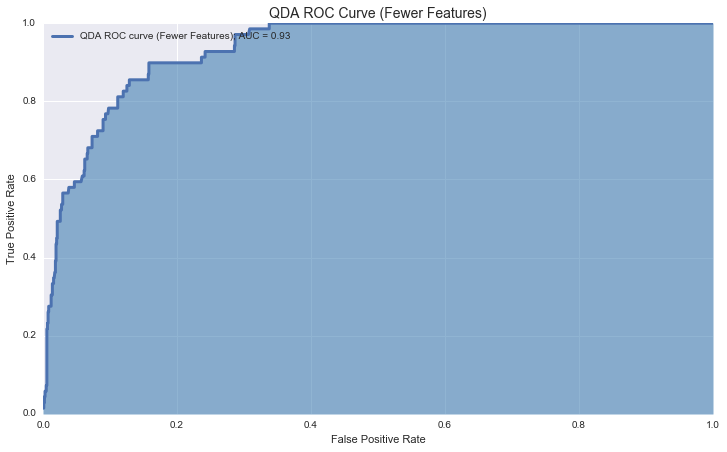

In [211]:
# Examine ROC curve and AUC.
y_hat_proba_qda_signal = best_qda_signal.predict_proba(X_test_signal_scaled)
qda_fpr_signal, qda_tpr_signal, thresholds_signal = roc_curve(y_test_signal, y_hat_proba_qda_signal[:,1])
qda_roc_auc_signal = auc(qda_fpr_signal, qda_tpr_signal)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(qda_fpr_signal, qda_tpr_signal, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(qda_fpr_signal, qda_tpr_signal, linewidth=3, label='QDA ROC curve (Fewer Features); AUC = %0.2f' % qda_roc_auc_signal)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('QDA ROC Curve (Fewer Features)', size=14)

##### SVC #####

In [212]:
# SVC with fewer features.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_signal = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_signal.fit(X_train_signal_scaled, y_train_signal)
best_svc_signal = clf_svc_signal.best_estimator_
y_hat_svc_signal = best_svc_signal.predict(X_test_signal_scaled)
confusion_matrix(y_test_signal, y_hat_svc_signal, labels=[1,0])

array([[   0,   69],
       [   0, 1096]])

In [215]:
# Examine metrics.
y_hat_proba_svc_signal = best_svc_signal.predict_proba(X_test_signal_scaled)
svc_fpr_signal, svc_tpr_signal, thresholds_signal = roc_curve(y_test_signal, y_hat_proba_svc_signal[:,1])
svc_roc_auc_signal = auc(svc_fpr_signal, svc_tpr_signal)
print('AUC: %0.2f' % svc_roc_auc_signal)
print(classification_report(y_test_signal, y_hat_svc_signal))

AUC: 0.90
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1096
          1       0.00      0.00      0.00        69

avg / total       0.89      0.94      0.91      1165



#### Over Sampling ####

Ultimately, just using fewer features did improve our AUC in general, but did not improve our predictive power for the positives class. What if we combine fewer features with over sampling?

In [216]:
# Multiply the number of positives by 6. We'll then add to the original database for 7x total positives.
positives = signal_df[signal_df['Purchase'] == 1]
for _ in range(4):
    positives = positives.append(signal_df[signal_df['Purchase'] == 1])

In [217]:
# Append negatives.
oversample_signal_df = signal_df.append(positives).sample(frac=1).reset_index(drop=True)

In [218]:
# Check size of new dataset.
oversample_signal_df.shape

(7562, 50)

In [219]:
# Check ratio of label values.
oversample_signal_df['Purchase'].value_counts()

0    5474
1    2088
Name: Purchase, dtype: int64

In [220]:
# Split data into X and y.
X_signal_over = oversample_signal_df.drop(['Purchase'], axis=1).values
y_signal_over = oversample_signal_df['Purchase'].factorize()[0]

In [221]:
# Normalize the data.
scaler = StandardScaler()
X_signal_scaled_over = scaler.fit_transform(X_signal_over)

In [222]:
# Train test split.
X_train_ss_over, X_test_ss_over, y_train_ss_over, y_test_ss_over = train_test_split(X_signal_scaled_over, y_signal_over, 
                                                                                    test_size=0.20, random_state=9)

##### Logistic Regression #####

In [225]:
# Logistic regression with fewer features, oversampled.
lr_signal_over = LogisticRegression()
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
clf_lr_signal_over = GridSearchCV(lr_signal_over, parameters, cv=10)
clf_lr_signal_over.fit(X_train_ss_over, y_train_ss_over)
best_lr_signal_over = clf_lr_signal_over.best_estimator_
y_hat_lr_signal_over = best_lr_signal_over.predict(X_test_ss_over)
print(confusion_matrix(y_test_ss_over, y_hat_lr_signal_over, labels=[1,0]))

[[979 106]
 [305 123]]


In [226]:
# Examine metrics.
y_hat_proba_lr_signal_over = best_lr_signal_over.predict_proba(X_test_ss_over)
lr_fpr_signal_over, lr_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_lr_signal_over[:,1])
lr_roc_auc_signal_over = auc(lr_fpr_signal_over, lr_tpr_signal_over)
print('AUC: %0.2f' % lr_roc_auc_signal_over)
print(classification_report(y_test_ss_over, y_hat_lr_signal_over))

AUC: 0.75
             precision    recall  f1-score   support

          0       0.54      0.29      0.37       428
          1       0.76      0.90      0.83      1085

avg / total       0.70      0.73      0.70      1513



This might be our best Logistic Regression model yet, at least for predicting elements of the positive class. Let's look at the others.

##### K-NN #####

In [227]:
# K-NN with fewer features, oversampled.
knn_signal_over = KNeighborsClassifier()
parameters = {'n_neighbors': [2,5,10,20]}
clf_knn_signal_over = GridSearchCV(knn_signal_over, parameters, cv=10)
clf_knn_signal_over.fit(X_train_ss_over, y_train_ss_over)
best_knn_signal_over = clf_knn_signal_over.best_estimator_
y_hat_knn_signal_over = best_knn_signal_over.predict(X_test_ss_over)
confusion_matrix(y_test_ss_over, y_hat_knn_signal_over, labels=[1,0])

array([[929, 156],
       [  3, 425]])

In [228]:
# Examine metrics.
y_hat_proba_knn_signal_over = best_knn_signal_over.predict_proba(X_test_ss_over)
knn_fpr_signal_over, knn_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_knn_signal_over[:,1])
knn_roc_auc_signal_over = auc(knn_fpr_signal_over, knn_tpr_signal_over)
print('AUC: %0.2f' % knn_roc_auc_signal_over)
print(classification_report(y_test_ss_over, y_hat_knn_signal_over))

AUC: 0.95
             precision    recall  f1-score   support

          0       0.73      0.99      0.84       428
          1       1.00      0.86      0.92      1085

avg / total       0.92      0.89      0.90      1513



This model rivals our straight over sampled model.

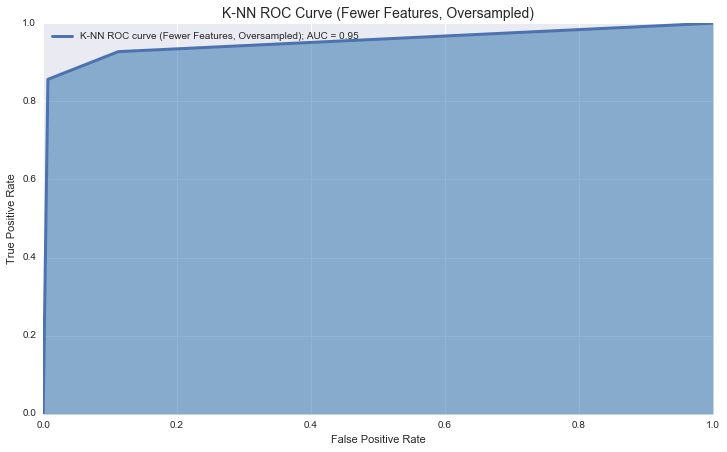

In [229]:
# Examine ROC curve and AUC.
y_hat_proba_knn_signal_over = best_knn_signal_over.predict_proba(X_test_ss_over)
knn_fpr_signal_over, knn_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_knn_signal_over[:,1])
knn_roc_auc_signal_over = auc(knn_fpr_signal_over, knn_tpr_signal_over)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(knn_fpr_signal_over, knn_tpr_signal_over, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(knn_fpr_signal_over, knn_tpr_signal_over, linewidth=3, label='K-NN ROC curve (Fewer Features, Oversampled); AUC = %0.2f' % knn_roc_auc_signal_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-NN ROC Curve (Fewer Features, Oversampled)', size=14)

##### LDA #####

In [230]:
# LDA with fewer features, oversampled.
lda_signal_over = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd', 'lsqr']}
clf_lda_signal_over = GridSearchCV(lda_signal_over, parameters, cv=10)
clf_lda_signal_over.fit(X_train_ss_over, y_train_ss_over)
best_lda_signal_over = clf_lda_signal_over.best_estimator_
y_hat_lda_signal_over = best_lda_signal_over.predict(X_test_ss_over)
confusion_matrix(y_test_ss_over, y_hat_lda_signal_over, labels=[1,0])

array([[976, 109],
       [286, 142]])

In [231]:
# Examine metrics.
y_hat_proba_lda_signal_over = best_lda_signal_over.predict_proba(X_test_ss_over)
lda_fpr_signal_over, lda_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_lda_signal_over[:,1])
lda_roc_auc_signal_over = auc(lda_fpr_signal_over, lda_tpr_signal_over)
print('AUC: %0.2f' % lda_roc_auc_signal_over)
print(classification_report(y_test_ss_over, y_hat_lda_signal_over))

AUC: 0.75
             precision    recall  f1-score   support

          0       0.57      0.33      0.42       428
          1       0.77      0.90      0.83      1085

avg / total       0.71      0.74      0.71      1513



##### QDA #####

In [232]:
# QDA with fewer features, oversampled.
qda_signal_over = QuadraticDiscriminantAnalysis()
parameters = {'reg_param': [0.0, 0.01, 0.05, 0.1, 0.5]}
clf_qda_signal_over = GridSearchCV(qda_signal_over, parameters, cv=10)
clf_qda_signal_over.fit(X_train_ss_over, y_train_ss_over)
best_qda_signal_over = clf_qda_signal_over.best_estimator_
y_hat_qda_signal_over = best_qda_signal_over.predict(X_test_ss_over)
confusion_matrix(y_test_ss_over, y_hat_qda_signal_over, labels=[1,0])

array([[853, 232],
       [156, 272]])

In [233]:
# Examine metrics.
y_hat_proba_qda_signal_over = best_qda_signal_over.predict_proba(X_test_ss_over)
qda_fpr_signal_over, qda_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_qda_signal_over[:,1])
qda_roc_auc_signal_over = auc(qda_fpr_signal_over, qda_tpr_signal_over)
print('AUC: %0.2f' % qda_roc_auc_signal_over)
print(classification_report(y_test_ss_over, y_hat_qda_signal_over))

AUC: 0.78
             precision    recall  f1-score   support

          0       0.54      0.64      0.58       428
          1       0.85      0.79      0.81      1085

avg / total       0.76      0.74      0.75      1513



##### SVC #####

In [234]:
# Classify with SVC.
parameters = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2]}
clf_svc_signal_over = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, scoring='roc_auc')
clf_svc_signal_over.fit(X_train_ss_over, y_train_ss_over)
best_svc_signal_over = clf_svc_signal_over.best_estimator_
y_hat_svc_signal_over = best_svc_signal_over.predict(X_test_ss_over)
confusion_matrix(y_test_ss_over, y_hat_svc_signal_over, labels=[1,0])

array([[978, 107],
       [108, 320]])

In [236]:
# Examine metrics.
y_hat_proba_svc_signal_over = best_svc_signal_over.predict_proba(X_test_ss_over)
svc_fpr_signal_over, svc_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_svc_signal_over[:,1])
svc_roc_auc_signal_over = auc(svc_fpr_signal_over, svc_tpr_signal_over)
print('AUC: %0.2f' % svc_roc_auc_signal_over)
print(classification_report(y_test_ss_over, y_hat_svc_signal_over))

AUC: 0.92
             precision    recall  f1-score   support

          0       0.75      0.75      0.75       428
          1       0.90      0.90      0.90      1085

avg / total       0.86      0.86      0.86      1513



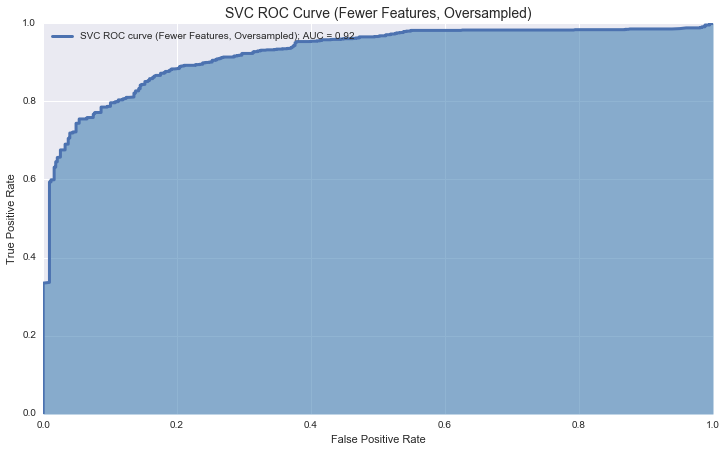

In [237]:
# Examine ROC curve and AUC.
y_hat_proba_svc_signal_over = best_svc_signal_over.predict_proba(X_test_ss_over)
svc_fpr_signal_over, svc_tpr_signal_over, thresholds_signal_over = roc_curve(y_test_ss_over, y_hat_proba_svc_signal_over[:,1])
svc_roc_auc_signal_over = auc(svc_fpr_signal_over, svc_tpr_signal_over)
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
ax1.fill_between(svc_fpr_signal_over, svc_tpr_signal_over, 0, color='steelblue', alpha=0.6)
ax1 = plt.plot(svc_fpr_signal_over, svc_tpr_signal_over, linewidth=3, label='SVC ROC curve (Fewer Features, Oversampled); AUC = %0.2f' % svc_roc_auc_signal_over)
plt.legend(loc='upper left')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve (Fewer Features, Oversampled)', size=14)

This is a great model. We have high AUC, high metrics for our positive class, and a large number of correctly classified positives.

Overall, while over sampling seems to have been our single most successful technique for getting a good AUC score alongside good metrics, combining over sampling with removing features with little signal allowed us to dramatically increase the number of correctly classified positives, which was ultimately our goal.